# Breast cancer data analysis using KNN & ANN



In [8]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from IPython.display import display, HTML;

Data Wrangling -

In [9]:
def clean():
    columnlist = ['Sample ID','Clump thickness','Uniformity of cell size','Uniformity of cell shape','Marginal adhesion','Single epithelial cell size','Number of bare nuclei','Bland chromatin','Number of normal nuclei','Mitosis','Classes']        
    df = pd.read_csv('bc.data', names = columnlist)
    
    #Drop sample ID column
    df = df.drop(['Sample ID'], axis = 1)
    
    df = df.apply(lambda x: pd.to_numeric(x, errors='coerce'))
    df = df.dropna(subset = ['Classes'])
    
    df["Classes"].replace({2:1, 4:0}, inplace=True)
    
    x = df.iloc[:, :9]
    y = df.iloc[:, -1]
        
    #Feature distribution plots
    featureDist(x, y, df)
    
    #Imputation
    imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imputer = imputer.fit(x)
    x = imputer.transform(x)
    
    sc = StandardScaler()

    #PCA
    pca(x, df)
    
    #Feature Heatmap
    plt.figure() 
    plt.title("Features Heatmap")
    sns.heatmap(sc.fit_transform(x), cbar=True, annot=False, yticklabels=df.columns, xticklabels=df.columns)
    plt.show()
    
    #Selecting K Best features
    x = SelectKBest(chi2, k=6).fit_transform(x, y)
    
    #Split data to test & train       
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)
    
    return x_train, x_test, y_train, y_test



In [10]:
def featureDist(x, y, df):
    
    #Feature distribution histogram
    plt.figure()
    plt.title("Benign & Malignant distribution plot (1 - Benign, 0 - Malignant)")
    sns.countplot(df['Classes'], label="Count")  
    plt.show()

    ##Feature distribution plot
    sc = StandardScaler()
    x = sc.fit_transform(x)
    data = pd.DataFrame(x, columns = ['Clump thickness','Uniformity of cell size','Uniformity of cell shape','Marginal adhesion','Single epithelial cell size','Number of bare nuclei','Bland chromatin','Number of normal nuclei','Mitosis'])
    data_n_2 = (data - data.mean()) / (data.std())
    data = pd.concat([y,data_n_2.iloc[:,0:10]],axis=1)
    data = pd.melt(data,id_vars="Classes", var_name="features", value_name='value')
    plt.figure()
    plt.title("Feature distribution plot (1 - Benign, 0 - Malignant)")
    sns.violinplot(x="features", y="value", hue="Classes", data=data,split=True, inner="quart")
    plt.xticks(rotation=90)
    plt.show()
    
    

Principal component Analysis - 

In [11]:
def pca(x, df):
    pca_breast = PCA(n_components=2)
    sc = StandardScaler()
    principalComponents_breast = pca_breast.fit_transform(sc.fit_transform(x))
    principal_breast_Df = pd.DataFrame(data = principalComponents_breast, columns = ['principal component 1', 'principal component 2'])
    
    print("\n\nPrincipal component Analysis - \n")
    print('Explained variation per principal component: {}'.format(pca_breast.explained_variance_ratio_))

    plt.figure()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=14)
    plt.xlabel('Principal Component - 1')
    plt.ylabel('Principal Component - 2')
    plt.title("PCA (1 - Benign, 0 - Malignant)")
    targets = [1, 0]
    colors = ['r', 'g']
    for target, color in zip(targets,colors):
        indicesToKeep = df['Classes'] == target
        plt.scatter(principal_breast_Df.loc[indicesToKeep, 'principal component 1']
                   , principal_breast_Df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)
    
    plt.legend(targets,prop={'size': 15})
    plt.show()
    
    

ANN - 

In [12]:
def sigmoid(x):
    return (1/(1+np.exp(-x)))

def sigmoid_prime(x):
    return x * (1 - x)

def neuralNetwork(x_train, y_train, x_test, y_test):
    w1, w2 = trainNeural(x_train, y_train)
    y_pred = testNeural(x_test, w1, w2)
    
    print("\nConfusion Matrix - ")
    tr = pd.DataFrame(data = confusion_matrix(y_test, y_pred), columns = ['B', 'M'], index = ['B', 'M'])
    display(HTML(tr.to_html()))
    
    print("Accuracy for Neural Network = ", accuracy_score(y_test, y_pred))
    
def meanSquareError(predictions, labels):
    N = labels.size 
    mse = ((predictions - labels)**2).sum() / (2*N)
    return mse

def trainNeural(x_train, y_train):
    
    input_nodes = len(x_train[0])
    hidden_nodes = 6
    output_nodes = 1
    learning_rate = 0.1
    
    y_train = y_train[:,None]

    epochs = 1200

    w1 = np.random.random((input_nodes, hidden_nodes)) #(x, 6)
    w2 = np.random.random((hidden_nodes, output_nodes)) #(6, 1)
    
    msePlot = []
    
    for e in range(epochs):
            
        #forward propogation
  
        #hidden layer
        hidden_layer = sigmoid(np.dot(x_train, w1))

        #output layer
        output_layer = sigmoid(np.dot(hidden_layer, w2))
        
        msePlot.append(meanSquareError(output_layer, y_train))
        
        #backward propogation
                    
        #calculate how far off each layer is
        output_layer_delta = (y_train - output_layer) * sigmoid_prime(output_layer)          
        hidden_layer_delta = output_layer_delta.dot(w2.T) * sigmoid_prime(hidden_layer)

        #update new weights
        w2 = np.add(w2, hidden_layer.T.dot(output_layer_delta) * learning_rate)
        w1 = np.add(w1, x_train.T.dot(hidden_layer_delta) * learning_rate)
    
    plt.figure()
    plt.plot(msePlot)
    plt.title("Mean square error graph")
    plt.ylabel('Error')
    plt.xlabel('Epochs')
    plt.show()
    
    return w1, w2

def testNeural(x_test, w1, w2):
    l1 = sigmoid(np.dot(x_test, w1))
    l2 = sigmoid(np.dot(l1, w2))
    y_pred = [(1 if x > 0.5 else 0) for x in l2] 
    return y_pred 



KNN - 

In [13]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))
    
def knn(x_train, y_train, x_test, y_test):  
    finalAcc = 0
    finalK = 0
    accuracies = np.zeros((26))
    final_y_pred = []
    for k in range(1, 26):
        y_pred = []
        y_pred = [predict(x, x_train, y_train, k) for x in x_test]
        acc = accuracy_score(y_test, np.array(y_pred))
        accuracies[k] = acc
        if acc > finalAcc:
            finalAcc = acc
            finalK = k
            final_y_pred = y_pred
    plt.figure()
    plt.title("Predictions vs accuracy graph")
    plt.xlabel("K-value")
    plt.ylabel("Accuracy")
    #plt.plot(range(1,26), accuracies[1:27], 'ro')
    
    print("\nConfusion Matrix - ")
    tr = pd.DataFrame(data = confusion_matrix(y_test, final_y_pred), columns = ['B', 'M'], index = ['B', 'M'])
    display(HTML(tr.to_html()))
    
    print("Accuracy for KNN = ", finalAcc, "for k = ", finalK)
    
def predict(x, x_train, y_train, k):
    
        #Compute distances between x and all examples in the training set
        distances = [euclidean_distance(x, y) for y in x_train]

        #Sort by distance and return indices of the first k neighbors
        distances_sorted = np.argsort(distances)[:k]
        
        #Extract the labels of the k nearest neighbor training samples
        k_list = [y_train[i] for i in distances_sorted]  
        
        #Extract most common occurance of values
        max = 0
        res = k_list[0] 
        for i in k_list: 
            freq = k_list.count(i) 
            if freq > max: 
                max = freq 
                res = i 

        return res

Main class - 

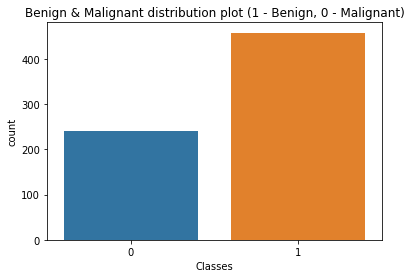

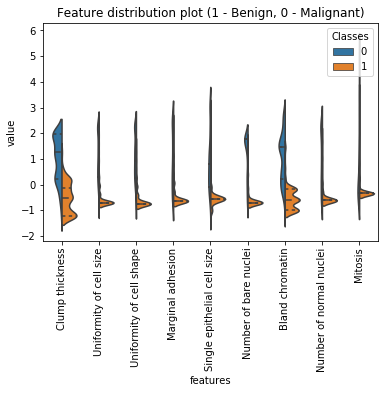



Principal component Analysis - 

Explained variation per principal component: [0.65445704 0.0860859 ]


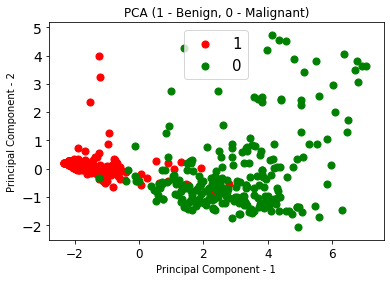

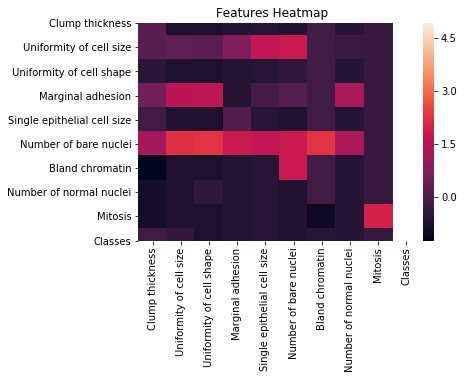



Artificial Neural Network - 


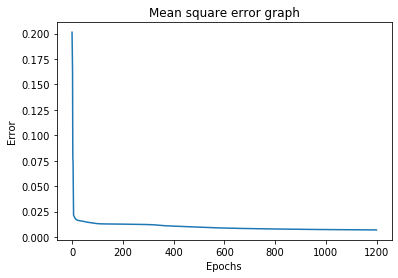


Confusion Matrix - 


,B,M
B,43,2
M,5,90


Accuracy for Neural Network =  0.95


KNN - 


Confusion Matrix - 


,B,M
B,43,2
M,2,93


Accuracy for KNN =  0.9714285714285714 for k =  11


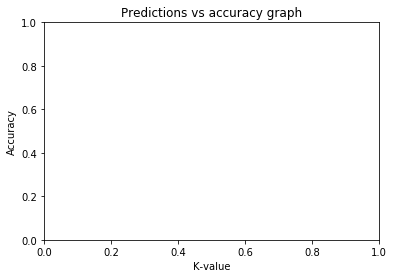

In [14]:
x_train, x_test, y_train, y_test = clean()

print("\n\nArtificial Neural Network - ")
neuralNetwork(x_train, y_train, x_test, y_test)

print("\n\nKNN - \n")
knn(x_train, np.array(y_train), x_test, y_test)